In [1]:
%load_ext autoreload
%autoreload 2
import sys

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(13)
from sklearn.datasets import fetch_openml, load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn import metrics

# installable with: `pip install imodels`
from imodels import SLIMRegressor, BayesianRuleListClassifier, RuleFitRegressor, GreedyRuleListClassifier
from imodels import OneRClassifier, BoostedRulesClassifier
from imodels.util.convert import tree_to_code

def get_reg_boston_data():
    '''load (regression) data on boston housing prices
    '''
    X_reg, y_reg = load_boston(return_X_y=True)
    feature_names = load_boston()['feature_names']
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.75) # split
    return X_train_reg, X_test_reg, y_train_reg, y_test_reg, feature_names

def get_diabetes_data():
    '''load (classification) data on diabetes
    '''
    df = fetch_openml("diabetes", version=1) # get dataset
    X = df.data
    y = (df.target == 'tested_positive').astype(np.int) # labels 0-1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75) # split
    feature_names = ["#Pregnant","Glucose concentration test","Blood pressure(mmHg)","Triceps skin fold thickness(mm)",
                  "2-Hour serum insulin (mu U/ml)","Body mass index","Diabetes pedigree function","Age (years)"]
    return X_train, X_test, y_train, y_test, feature_names
    

X_train_reg, X_test_reg, y_train_reg, y_test_reg, feat_names_reg = get_reg_boston_data()
X_train, X_test, y_train, y_test, feat_names = get_diabetes_data()


def viz_classification_preds(probs, y_test):
    '''look at prediction breakdown
    '''
    plt.subplot(121)
    plt.hist(probs[:, 1][y_test==0], label='Class 0')
    plt.hist(probs[:, 1][y_test==1], label='Class 1', alpha=0.8)
    plt.ylabel('Count')
    plt.xlabel('Predicted probability of class 1')
    plt.legend()
    
    plt.subplot(122)
    preds = np.argmax(probs, axis=1)
    plt.title('ROC curve')
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.plot(fpr, tpr)
    plt.tight_layout()
    plt.show()

# load some data
print('regression data', X_train_reg.shape, 'classification data', X_train.shape)

regression data (126, 13) classification data (192, 8)


# rule sets
Rule sets are models that create a set of (potentially overlapping) rules.

### rulefit

In [2]:
# fit a rulefit model
rulefit = RuleFitRegressor(max_rules=10)
rulefit.fit(X_train_reg, y_train_reg, feature_names=feat_names_reg)

# get test performance
preds = rulefit.predict(X_test_reg)
print(f'test r2: {metrics.r2_score(y_test_reg, preds):0.2f}')


# inspect and print the rules
rules = rulefit.get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)

# 'rule' is how the feature is constructed
# 'coef' is its weight in the final linear model
# 'support' is the fraction of points it applies to
rules[['rule', 'coef', 'support']].style.background_gradient(cmap='viridis')

test r2: 0.73


,rule,coef,support
5,RM,0.454582,1.000000
7,DIS,-0.165810,1.000000
10,PTRATIO,-0.208522,1.000000
11,B,0.004217,1.000000
12,LSTAT,-0.248097,1.000000
15,LSTAT > 4.475 and RM <= 6.978,-10.042910,0.833333
14,LSTAT > 7.695,-3.469408,0.682540
16,LSTAT <= 7.695,0.040990,0.317460
13,LSTAT > 16.04,-2.995351,0.269841
17,LSTAT <= 7.315 and RM > 7.3525,4.308702,0.055556


## boosted stumps

Mined rules:
	Glucose concentration test <= 128.5
	Body mass index <= 28.949999809265137
	Age (years) <= 27.5
	Age (years) <= 27.5
	Blood pressure(mmHg) <= 75.0
	Body mass index <= 28.949999809265137
	Body mass index <= 28.949999809265137
	Glucose concentration test <= 183.5
	Diabetes pedigree function <= 0.27150000631809235
	2-Hour serum insulin (mu U/ml) <= 8.0



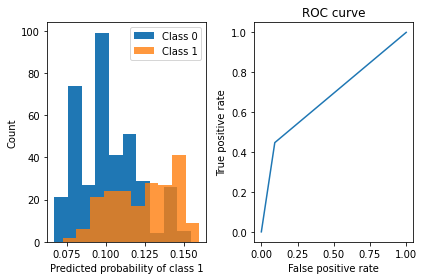

In [3]:
# fit boosted stumps
brc = BoostedRulesClassifier(n_estimators=10)
brc.fit(X_train, y_train, feature_names=feat_names)

print(brc)

# look at performance
probs = brc.predict_proba(X_test)
viz_classification_preds(probs, y_test)

# rule lists

### greedy rule lists
**like a decision tree that only ever splits going left**

mean 0.359 (192 pts)
if Glucose concentration test >= 129.0 then 0.691 (68 pts)
mean 0.177 (124 pts)
if Body mass index >= 29.0 then 0.28 (75 pts)
mean 0.02 (49 pts)
if Blood pressure(mmHg) >= 96.0 then 1.0 (1 pts)
mean 0 (48 pts)



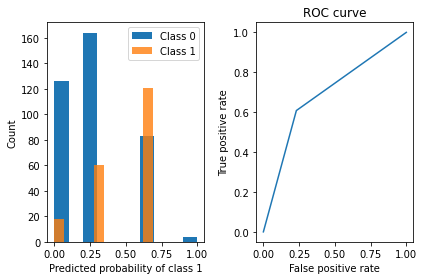

In [4]:
# fit a greedy rule list
m = GreedyRuleListClassifier()
m.fit(X_train, y=y_train, feature_names=feat_names) # stores into m.rules_
probs = m.predict_proba(X_test)

# print the list
print(m)

# look at prediction breakdown
viz_classification_preds(probs, y_test)

### oneR
**fits a rule list restricted to use only one feature**

/Users/keyan/anaconda3/envs/imodels-3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/keyan/anaconda3/envs/imodels-3.6/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean 0.359 (192 pts)
if Glucose concentration test >= 129.0 then 0.691 (68 pts)
mean 0.177 (124 pts)
if Glucose concentration test >= 102.0 then 0.262 (65 pts)
mean 0.085 (59 pts)
if Glucose concentration test >= 91.0 then 0.133 (30 pts)
mean 0.034 (29 pts)
if Glucose concentration test >= 100.0 then 0.167 (6 pts)
mean 0 (23 pts)



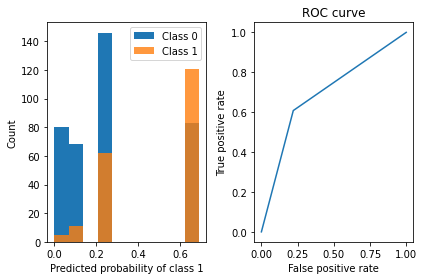

In [5]:
# fit a oneR model
m = OneRClassifier()
m.fit(X_train, y=y_train, feature_names=feat_names) # stores into m.rules_
probs = m.predict_proba(X_test)

# print the rule list
print(m)

# look at prediction breakdown
viz_classification_preds(probs, y_test)

### scalable bayesian rule lists

training...
learned model:
 Trained RuleListClassifier for detecting diabetes
IF plas_128.5_to_inf THEN probability of diabetes: 68.6% (57.3%-78.8%)
ELSE IF mass_28.95_to_inf THEN probability of diabetes: 28.6% (19.1%-39.1%)
ELSE IF pres_All THEN probability of diabetes: 3.9% (0.5%-10.6%)
ELSE probability of diabetes: 50.0% (2.5%-97.5%)



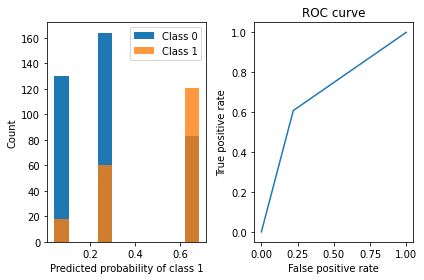

In [6]:
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training...')
m = BayesianRuleListClassifier(max_iter=3000, class1label="diabetes", verbose=False)
m.fit(X_train, y_train)
probs = m.predict_proba(X_test)
print("learned model:\n", m)
viz_classification_preds(probs, y_test)

# rule trees

### short decision tree

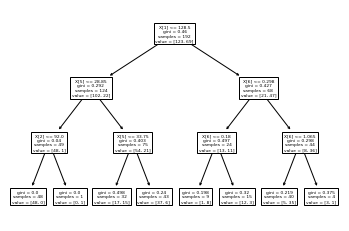

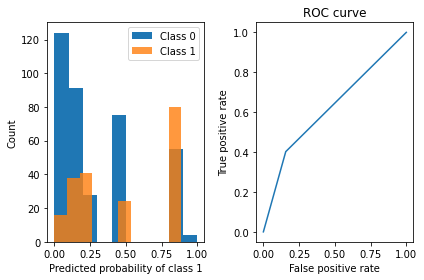

In [7]:
# specify a decision tree with a maximum depth
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

# calculate mse on the training data
probs = dt.predict_proba(X_test)
# print(f'test mse: {np.mean(np.square(preds-y)):0.2f}')

plot_tree(dt)
# plt.savefig('tree.pdf')
plt.show()

viz_classification_preds(probs, y_test)

### optimal classification tree
- docs [here](https://github.com/csinva/interpretability-workshop/tree/master/imodels/optimal_classification_tree)
- note: this implementation is still somewhat unstable, and can be made faster by installing either `cplex` or `gurobi`

In [3]:
# sys.path.append('../imodels/optimal_classification_tree/pyoptree')
# sys.path.append('../imodels/optimal_classification_tree/')

In [ ]:
# from optree import OptimalTreeModel
# feature_names = np.array(["x1", "x2"])

# X = np.array([[1, 2, 2, 2, 3], [1, 2, 1, 0, 1]]).T
# y = np.array([1, 1, 0, 0, 0]).reshape(-1, 1)
# X_test = np.array([[1, 1, 2, 2, 2, 3, 3], [1, 2, 2, 1, 0, 1, 0]]).T
# y_test = np.array([1, 1, 1, 0, 0, 0, 0])

# np.random.seed(13)
# model = OptimalTreeModel(tree_depth=3, N_min=1, alpha=0.1) #, solver_name='baron'
# model.fit(X_test, y_test) # this method is currently using the fast, but not optimal solver
# preds = model.predict(X_test)

# # fit on the bigger diabetes dset from above
# # model.fit(Xtrain, ytrain) # this method is currently using the fast, but not optimal solver
# # preds = model.predict(Xtest)

# print('acc', np.mean(preds == y_test))

In [10]:
# model.print_tree(feature_names)

depth 0:
	 x2 > 0.8114524236945737

depth 1:
	node 2 undefined
	node 3 undefined

depth 2:
	node 4 undefined
	 x1 > 0.01086684288089712
	 x2 > 0.9159532769401844
	node 7 undefined

depth 3:
	node 8 undefined
	node 9 undefined
	node 10 undefined
	node 11 undefined
	node 12 undefined
	node 13 undefined
	node 14 undefined
	node 15 undefined



# algebraic models

### integer linear models

In [8]:
np.random.seed(123)

# generate X and y
n, p = 500, 10
X_sim = np.random.randn(n, p)
y_sim = 1 * X_sim[:, 0] + 2 * X_sim[:, 1] - 1 * X_sim[:, 2] + np.random.randn(n)

# fit linear models with different regularization parameters
print('groundtruth weights should be 1, 2, -1...')
model = SLIMRegressor()
for lambda_reg in [0, 1e-2, 5e-2, 1e-1, 1, 2]:
    model.fit(X_sim, y_sim, lambda_reg)
    mse = np.mean(np.square(y_sim - model.predict(X_sim)))
    print(f'lambda: {lambda_reg}\tmse: {mse: 0.2f}\tweights: {model.model.coef_}')

groundtruth weights should be 1, 2, -1...
lambda: 0	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]
lambda: 0.01	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]
lambda: 0.05	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]
lambda: 0.1	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]
lambda: 1	mse:  3.94	weights: [0 1 0 0 0 0 0 0 0 0]
lambda: 2	mse:  7.14	weights: [0 0 0 0 0 0 0 0 0 0]


/Users/keyan/anaconda3/envs/imodels-3.6/lib/python3.6/site-packages/imodels/algebraic/slim.py:60: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  m.fit(X, y, sample_weight=sample_weight)
/Users/keyan/anaconda3/envs/imodels-3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/keyan/anaconda3/envs/imodels-3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229.54007924516694, tolerance: 0.3572231461180381
  positive)
